### [Pytorch 기반 회귀 모델 구현]
- Layer : Full-Connected Layer (linear)
- 손실함수 : MSELoss, MAELoss, ...
- optimizer : Adam, NAdam, RAdam, ...

[1] 데이터 준비

In [1]:
import pandas as pd

In [2]:
filename = './BostonHousing.csv'

bostonDF = pd.read_csv(filename, encoding='utf-8')
bostonDF.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [4]:
# 중복치 없음
bostonDF.duplicated().sum()

0

In [5]:
# 피처, 타겟 분리
featureDF = bostonDF[bostonDF.columns[:-1]]
targetSR = bostonDF[bostonDF.columns[-1]]

[2] 사용자 데이터셋 클래스 정의

In [6]:
from sklearn.model_selection import train_test_split

### 훈련용, 테스트용 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(455, 13) (455,) (51, 13) (51,)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [8]:
import numpy as np

### 클래스 정의
class BostonDS(Dataset):

    # 데이터 전처리 => 정규화, 텐서화
    def __init__(self, feature, target):
        super().__init__()
        self.feature = torch.FloatTensor(feature.values)
        self.target = torch.FloatTensor(target.values)
        self.length = self.feature.shape[0]
        # self.normalization()

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.feature[index], self.target[index]
    
    # 데이터 정규화 기능함수
    def normalization(self):
        # self.feature.max(dim=1)
        return self.feature / np.max(self.feature)

In [9]:
# 데이터셋 생성
trainDS = BostonDS(x_train, y_train)
testDS = BostonDS(x_test, y_test)

In [10]:
# DataLoader 생성
BATCH_SIZE = 32

trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)
testDL = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
for feature, target in trainDL:
    print(feature.shape, target.shape)

torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([7, 13]) torch.Size([7])


[3] 모델 생성

In [12]:
### 간단한 회귀 모델 정의
class BostonRegModel(nn.Module):

    def __init__(self, in_):
        super().__init__()
        self.linear1 = nn.Linear(in_, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [13]:
### 성능 좋은 회귀 모델
class BostonHousingRegressor(nn.Module):
    def __init__(self, in_):
        super().__init__()
        self.fc1 = nn.Linear(in_, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [14]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_features = len(featureDF.columns)

MODEL = BostonHousingRegressor(n_features).to(device)
# MODEL = BostonRegModel(n_features).to(device)
# MODEL = nn.Sequential(
#     nn.Linear(13, 64),
#     nn.ReLU(),
#     nn.Linear(64, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1)
# ).to(device)

CRITERION = nn.MSELoss().to(device)
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=0.001)    # SGD 쓰면 ㄷㄷ...

In [15]:
# 학습
from sklearn.metrics import r2_score

def training(epoch, dataloader, model, criterion, optimizer):

    loss_list, r2_list = [], []

    model.train()

    for idx, (feature, target) in enumerate(dataloader):
        # 순전파
        output = model(feature)
        loss = criterion(output, target.unsqueeze(1))   # 2차원으로 통일
        loss_list.append(loss.item())                   # loss가 단일 요소라서, item() 적용 가능
        r2 = r2_score(target, output.detach().squeeze())
        r2_list.append(r2)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print(f'[Epoch {epoch: 2d}] loss : {np.mean(loss_list):.4f}')
    return np.mean(loss_list), np.mean(r2_list)

In [16]:
EPOCHS = 1000
loss_list, r2_list = [], []

for epoch in range(EPOCHS):
    loss, r2 = training(epoch, trainDL, MODEL, CRITERION, OPTIMIZER)
    loss_list.append(loss)
    r2_list.append(r2)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1:3d}/{EPOCHS}], Loss: {loss_list[-1]:.4f} r2: {r2_list[-1]:.4f}')

Epoch [ 10/1000], Loss: 66.8223 r2: 0.2512
Epoch [ 20/1000], Loss: 60.5694 r2: 0.3030
Epoch [ 30/1000], Loss: 47.7622 r2: 0.3359
Epoch [ 40/1000], Loss: 45.5976 r2: 0.4249
Epoch [ 50/1000], Loss: 36.2664 r2: 0.5035
Epoch [ 60/1000], Loss: 34.7861 r2: 0.6006
Epoch [ 70/1000], Loss: 41.5017 r2: 0.4869
Epoch [ 80/1000], Loss: 27.7384 r2: 0.6625
Epoch [ 90/1000], Loss: 29.2490 r2: 0.6468
Epoch [100/1000], Loss: 25.6401 r2: 0.6221
Epoch [110/1000], Loss: 21.7118 r2: 0.7115
Epoch [120/1000], Loss: 20.7030 r2: 0.7307
Epoch [130/1000], Loss: 27.5480 r2: 0.6492
Epoch [140/1000], Loss: 19.7465 r2: 0.7306
Epoch [150/1000], Loss: 17.3558 r2: 0.7806
Epoch [160/1000], Loss: 16.5687 r2: 0.8018
Epoch [170/1000], Loss: 18.0297 r2: 0.7889
Epoch [180/1000], Loss: 17.8228 r2: 0.7541
Epoch [190/1000], Loss: 16.8695 r2: 0.8017
Epoch [200/1000], Loss: 15.1431 r2: 0.7550
Epoch [210/1000], Loss: 16.7925 r2: 0.7903
Epoch [220/1000], Loss: 17.6540 r2: 0.7809
Epoch [230/1000], Loss: 16.5039 r2: 0.7627
Epoch [240/

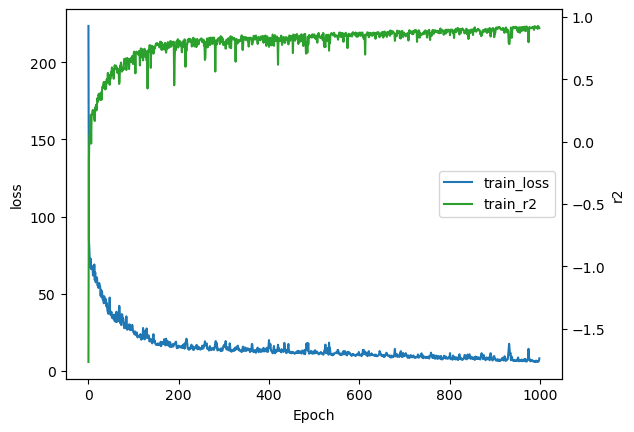

In [17]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# 첫 번째 선 그래프 그리기 (왼쪽 y축)
ax1.plot(loss_list, label='train_loss', color='tab:blue')

# 두 번째 y축 생성 및 두 번째 그래프 그리기
ax2 = ax1.twinx()
ax2.plot(r2_list, label='train_r2', color='tab:green')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax2.set_ylabel('r2')

plt.show()

In [18]:
# 모델 저장
modelname = './boston_reg_model.pth'
torch.save(MODEL, modelname)

In [19]:
# 모델 불러오기
MODEL = torch.load(modelname)